In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T

import os

import matplotlib.pyplot as plt

## Create Deconvolution Layer

In [ ]:
!rm DeconvModels.py
!rm training_functions.py
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_regression_model, train_classification_model

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory


## Mount my Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and preprocess image

In [ ]:
base_path = 'drive/MyDrive/data/lena/'
img = torchvision.io.read_image(base_path+'Lenna.png',
                                torchvision.io.ImageReadMode.GRAY)

img = T.Resize((48, 48))(img)

img = nn.functional.pad(img, (24, 24, 24, 24))
img = img / 255.0
img.size()

torch.Size([1, 96, 96])

## Blur the image

In [ ]:
w = torch.FloatTensor([[1, 0.2, 0, 0], [0.2, 0, 0, 0]])

# 4 factor blur

hm1 = nn.functional.pad(w, (0, img.size(-1)-w.size(-1), 0, img.size(-2)-w.size(-2)))

gm1f = fft2(hm1)

gm2f = torch.flip(gm1f, (0,))
gm2f = torch.roll(gm2f, shifts=1, dims=0)

gm3f = torch.flip(gm1f, (1,))
gm3f = torch.roll(gm3f, shifts=1, dims=1)

gm4f = torch.flip(gm1f, (0, 1))
gm4f = torch.roll(gm4f, shifts=(1, 1), dims=(0,1))

gmf = gm1f*gm2f*gm3f*gm4f

ymf = gmf*fft2(img)

X = ifft2(ymf).real

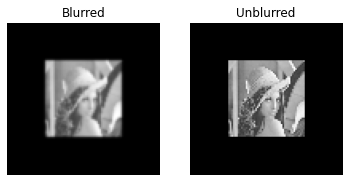

In [ ]:
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(X[0, :, :], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 2, 2)
plt.imshow(img[0, :, :], cmap='gray')
plt.axis('off')
plt.title('Unblurred')

plt.show()

## Intialise optimizer and loss function

In [ ]:
# Initialise variables
model = Deconv2D((2, 4))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

y = img

## Train deconv layer on the image

In [ ]:
num_epochs = 2000

for epoch in range(num_epochs):
    model.train()

    with torch.set_grad_enabled(True):
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1)%50 == 0:
        print('Epoch {:04d} loss: {:.4f}'.format(epoch+1, loss))
    

Epoch 0050 loss: 0.0106
Epoch 0100 loss: 0.0017
Epoch 0150 loss: 0.0009
Epoch 0200 loss: 0.0006
Epoch 0250 loss: 0.0004
Epoch 0300 loss: 0.0003
Epoch 0350 loss: 0.0002
Epoch 0400 loss: 0.0002
Epoch 0450 loss: 0.0002
Epoch 0500 loss: 0.0001
Epoch 0550 loss: 0.0001
Epoch 0600 loss: 0.0001
Epoch 0650 loss: 0.0001
Epoch 0700 loss: 0.0001
Epoch 0750 loss: 0.0001
Epoch 0800 loss: 0.0001
Epoch 0850 loss: 0.0001
Epoch 0900 loss: 0.0001
Epoch 0950 loss: 0.0000
Epoch 1000 loss: 0.0000
Epoch 1050 loss: 0.0000
Epoch 1100 loss: 0.0000
Epoch 1150 loss: 0.0000
Epoch 1200 loss: 0.0000
Epoch 1250 loss: 0.0000
Epoch 1300 loss: 0.0000
Epoch 1350 loss: 0.0000
Epoch 1400 loss: 0.0000
Epoch 1450 loss: 0.0000
Epoch 1500 loss: 0.0000
Epoch 1550 loss: 0.0000
Epoch 1600 loss: 0.0000
Epoch 1650 loss: 0.0000
Epoch 1700 loss: 0.0000
Epoch 1750 loss: 0.0000
Epoch 1800 loss: 0.0000
Epoch 1850 loss: 0.0000
Epoch 1900 loss: 0.0000
Epoch 1950 loss: 0.0000
Epoch 2000 loss: 0.0000


## Unblur image using deconv layer

In [ ]:
model.eval()
y_pred = model(X)

## Plot Original, Blurred, and Deblurred

Text(0.5, 1.0, 'Original')

<Figure size 8000x24000 with 0 Axes>

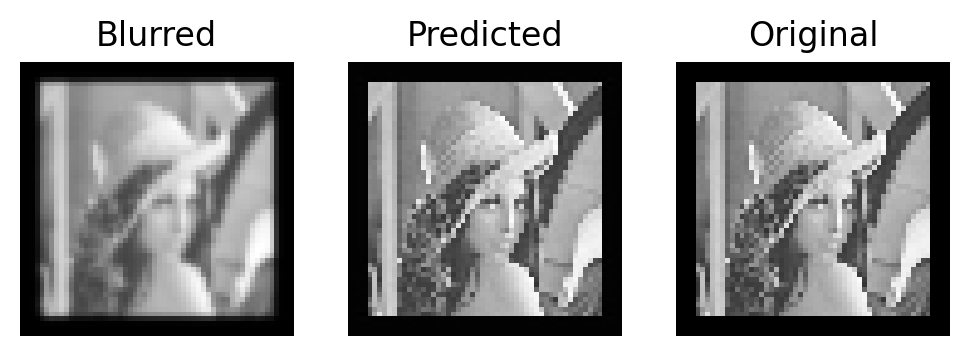

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(40, 120))

plt.subplots(1, 2)

plt.subplot(1, 3, 1)
plt.imshow(X[0, 20:76, 20:76], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[0, 20:76, 20:76].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 20:76, 20:76], cmap='gray')
plt.axis('off')
plt.title('Original')

## Deconvolution Kernel

In [ ]:
model.w_flat

Parameter containing:
tensor([ 0.1882,  0.0057,  0.0054,  0.1986,  0.0153, -0.0073, -0.0059],
       requires_grad=True)

In [ ]:
with torch.set_grad_enabled(False):
    w = nn.functional.pad(model.w_flat, (1, 0), value=1)
    w = torch.reshape(w, model.h_shape)
    print(torch.round(w, decimals=3))

tensor([[ 1.0000,  0.1880,  0.0060,  0.0050],
        [ 0.1990,  0.0150, -0.0070, -0.0060]])
